# Coronavirus modelisation

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import datetime 
from datetime import date
import numpy as np
import math
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pylab as plt

# simulate populations evolution during the coronavirus epidemy

The following function simulate roughtly how the population evolves while the virus spread


## high level explaination
    
there are 3 main categories, 
- *uninfected* representing the population untouched by the virus, 
- *infectiuos*, the people currently infected
- and *previously infected* ( cured or dead)

Each day, the people that where infected infection_time days before are transfered from infectious to cured or dead, the people still infectious infect new people. This constitue *delta*, the number of people that used to be uninfected that are contaminated the curent day.
<br>
This delta is varing with the number of currently infectious peoples by a percentage *r* calculated with the doubeling time (r = 70/doubeling_time) [Wikipedia](https://en.wikipedia.org/wiki/Doubling_time).

This delta is taken from uninfected, and become infectious, they will stop to be 15 days later, and so on...
<br>
The model is an  implemention of The SIR Model Without Vital Dynamics from [Three Basic Epidemiological by HW Hethcote](https://link.springer.com/chapter/10.1007/978-3-642-61317-3_5)
<br>
The main difference is that instead of taking a % of the infectious pop to be cured, i take the population infected *infection_time* days before



## 2 utilities functions
estimates_unknown_previous_new_cases allow us to estimate missing data, when we initialiwe the first day, we don't want to add the last month of new cases and number of active cases. instead we can estimates them based on the fact that at the beginning of the epidemic the we have an exponential growth.

In [173]:
def estimates_unknown_previous_new_cases(first_known_val, distance, growth_rate):
    """
    when we start the simulation, some data is often missing, especially the number of new cases in the previous days. 
    This function allow to estimates the missing point based on the growth rate and the the first known value
    """
    # the new cases doesn't follow exactly the growth rate because of the decay
    ajusted_growth_rate = growth_rate * 0.9759453945528388
    n = math.log(first_known_val)/ math.log( ajusted_growth_rate)
    if distance > n:
        result = 0
    else:
        result =ajusted_growth_rate**(n - distance)
    #print(first_known_val, distance, result )
    return result
examples = [ 1.1**i for i in range(1,21)]

#examples, estimates_unknown_previous_new_cases(examples[-1], 2, 1.1)


Instead of simply removing the cases from 15 days before, we can use a normal distribution to remove some cases on the days surrounding the average. This allow to simulate that some people heal in less than 15 days and some require more time. We use the distribution that we can see on the plot below to improve our estimation of cured patients

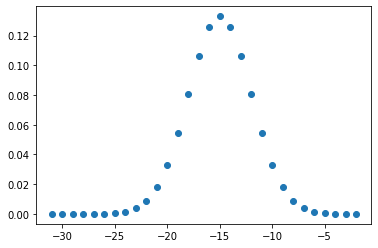

In [168]:
mu=-15 
sigma=3
bins = np.array([i for i in range(2* mu -1 , -1)])
normal_distrib = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) )
plt.scatter(bins, normal_distrib)


In [171]:
def refined_infecious_removal(deltas, growth_rate, mu=-15, sigma=3):
    """
    follow a normal distribution pattern for the time people stay infected instead or removing the infecious of X days before
    """
    bins = np.array([i for i in range(2* mu -1 , -1)])
    normal_distrib = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) )
    
    return np.sum(
        [
            deltas[deltas_i] * normal_distrib[i] 
            if len(deltas) > abs(deltas_i) 
            else estimates_unknown_previous_new_cases(
                deltas[0], 
                abs(len(deltas) + deltas_i), 
                growth_rate
            ) * normal_distrib[i] 
            for i, deltas_i in enumerate(bins)
        ]
    )
deltas = [100 * 1.1**i for i in range(15, 31)]
#deltas, refined_infecious_removal(deltas, growth_rate=1.1)



## the function parameters 
this function calculate the evolution of proportions of unifected, infectious, cured, dead people among a population as the virus spread
 - the size of the population
 - doubling time ( number of days for the number of infectious people to double)
 - number of infectious people today ( active cases)
 - current number of cured people
 - current number of dead people
 - number of new cases today
 - mortality rate (default from [worldometers](https://www.worldometers.info/coronavirus/country/south-korea/) nb of death / nb of cases ), 
 - hospitalisation rate (default at 0.01 [worldometers](https://www.worldometers.info/coronavirus/country/south-korea/))
 - infection time. avegage number of days to heal or die
 - number of days to run the simulation
 - annealing is to simulate progressive lockdown and back to more freedom of move


In [160]:
def generate_series(population, doubling_time, todays_estimates, today_cured=0, today_dead=0, today_new_cases=0, mortality_rate=0.01, hospitalization_rate=0.02, infection_time=15, number_of_days_to_simulate=200, with_annealing=None, with_season=None, use_normal_ditribution_cure=False):
    # calculate contant grow time per day
    r = 70/doubling_time
    
    uninfected = [population]
    infectious = [todays_estimates]
    needs_hospitalization = [todays_estimates * hospitalization_rate]
    mild_cases = [todays_estimates * (1- hospitalization_rate)]
    cured = [today_cured]
    
    dead = [today_dead]
    deltas = [estimates_unknown_previous_new_cases(todays_estimates, infection_time, 1+r/100)]
    
    if  with_annealing is None:
        x = np.ones(2) 
    else:
        x = with_annealing 
    
    if  with_season is None:
        xs = np.ones(2) 
    else:
        xs = with_season 
    
    print("daily increase :",r, '%', 1 + r/100)
    for i in range(number_of_days_to_simulate):
        if use_normal_ditribution_cure:
            decay = refined_infecious_removal(deltas, 1 + r/100, mu=-infection_time, sigma = infection_time / 5)
        else:
            decay = 0
            # people get cured and gain immunity
            if i >= infection_time:
                decay = deltas[-infection_time]
          
        cured.append(cured[-1] + decay * (1 - mortality_rate))
        # mortality
        dead.append(dead[-1]+ decay * ( mortality_rate))
        # still infectious people after removing cured people
        infectious_after_decay = max(infectious[-1] - decay, 0)
        # fraction of the population still uninfected
        logistic_factor = uninfected[-1]/ uninfected[0]
        
        
        delta = min(infectious_after_decay * logistic_factor * x[i % x.shape[0]] * xs[i % xs.shape[0]] * r/ 100, uninfected[-1])
        #print(i, delta, infectious_after_decay, logistic_factor, r / 100, infectious[-1])
        deltas.append(delta)
        infectious.append(infectious_after_decay + delta)
        uninfected.append(uninfected[-1] - delta)
        needs_hospitalization.append(infectious[-1] * hospitalization_rate)
        mild_cases.append(infectious[-1] * (1-hospitalization_rate))
        if uninfected[-1] <= 0:
            print('all contaminated')
            break
    
    # search where we are in the logistic curve, we check when the 
 
    todays_i = 0
    df_data = []
    df_data2 = []
    current_date = datetime.datetime.now()
    for i in range(todays_i, number_of_days_to_simulate):
        df_data.append({
            "date": current_date.strftime("%d/%m/%Y"),
            'infected': uninfected[0] - uninfected[i],
            "infectious":infectious[i],
            "deltas":deltas[i],
            "cured":cured[i],
            'dead':dead[i],
            'uninfected':uninfected[i],
            'sever_cases':needs_hospitalization[i] , 
            'mild_cases':mild_cases[i]
            
        })
        
        for t in [ 'cured', 'dead', 'sever_cases', 'mild_cases', 'uninfected']:
            
            df_data2.append({
                "i":i,
                "date": current_date.strftime("%d/%m/%Y"),
                "count":df_data[-1][t],
                'type':t,
                'country':'france'
            })
        current_date += datetime.timedelta(days=1)
    return pd.DataFrame(df_data), pd.DataFrame(df_data2)



In [135]:
def plot(population, doubling_rate, currently_infectious, number_of_days_to_simulate, with_annealing=None, with_season=None, use_normal_ditribution_cure=False):
    df_country, df_c2 = generate_series(population, doubling_rate, currently_infectious, number_of_days_to_simulate=number_of_days_to_simulate, with_annealing=with_annealing, with_season=with_season, use_normal_ditribution_cure=use_normal_ditribution_cure)
    
    groups=[ 'cured', 'dead', 'sever_cases', 'mild_cases', 'uninfected']
    fig = go.Figure(data=[ go.Bar(name=g, x=df_country["date"], y=df_country[g] ) for g in groups])
    fig.update_layout(barmode='stack',bargap=0,bargroupgap=0, title="evolution of population")
    fig.show()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_country["date"], y=df_country["deltas"], fill='tozeroy', name="New cases per day")) # fill down to xaxis
    fig.add_trace(go.Scatter(x=df_country["date"], y=df_country["sever_cases"], fill='tozeroy', name='Sever cases')) # fill to trace0 y
    fig.update_layout( title="New cases per day and Sever cases")
    fig.show()
    
    

In [177]:
#df_country, df_c2 = generate_series(66900000, 4, 12000, number_of_days_to_simulate=50, use_normal_ditribution_cure=True)
#df_country


We can now compare few countries bases on their growth rates
According to 
Max Roser, Hannah Ritchie and Esteban Ortiz-Ospina (2020) - "Coronavirus Disease (COVID-19) – Statistics and Research". Published online at OurWorldInData.org. Retrieved from: https://ourworldindata.org/coronavirus [Online Resource]

the growth rates are different per country:

China	doubled in 35 days <br>
Italy	doubled in 5 days <br>
Iran	doubled in 6 days <br>
South Korea	doubled in 15 days <br> 
Spain	doubled in 3 days <br>
France	doubled in 4 days <br>
Germany	doubled in 3 days <br>
United States	doubled in 5 days <br>
United Kingdom	doubled in 3 days  <br>

# France with growth rate observed before the lockdown

with a population of 67 million people, a doubling rate every 4 days, and an approximate number of infectious cases of 18000 (calculated with the number of death in the country and the mortality of south korea) as most cases are not detected in this country we cannot us official digits


In [175]:
plot(66900000, 4, 12000, number_of_days_to_simulate=150, use_normal_ditribution_cure=True)

daily increase : 17.5 % 1.175


### Analysis and comments
- The number of infected people reaches 80% of the pop in early june
- the pike of new cases is the 14/05 
- the number of sever cases goes up to 600k late may
- number of victims go up to 600k
- we can observe the transition of the population is very fast and with a number of infectious people being a significant portion of the pop


# France after lockdown
Lets imagine that the lockdown is just a little bit less efficient than in China and that the doubling time is around 20


In [176]:
plot(66900000, 70, 12000, number_of_days_to_simulate=365)

daily increase : 1.0 % 1.01


### Analysis and comments
- The number grow linearly and no more exponentially
- the pike is  not reached in the next year 
- the number of sever cases stay below 500
- most of the pop remain untouched by the virus

# Seasonality

The spanish flu had 3 waves, the coronavirus could also be sensitive to seasons. we will use the following function to modulate the probability of the virus to infect new people. This function is cloth to 0 during summer months

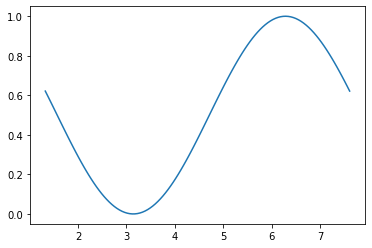

In [93]:

f_date = date(2020,1,1)
l_date = date.today()
delta = l_date - f_date
portion_of_year = 2*np.pi * delta.days / 365
x = np.linspace(portion_of_year, 2*np.pi +portion_of_year, 120)
_ = plt.plot(x, (1 + np.cos(x))/2  )

In [140]:
plot(66900000, 5, 12000, number_of_days_to_simulate=400, with_season=(1 + np.cos(np.linspace(portion_of_year, 2*np.pi +portion_of_year, 365))/2 )) 


daily increase : 14.0 % 1.1400000000000001


we can observe 2 pikes, the second occurres in autumn and is the most powerful

# Simulate a progressive stop of lockdown measures

we will use the following function to describe the lockdown removal. After 3 months, the number of cases decreases, the economy does't look good and the government remove social distanciation measures progressively, until the disease spread again, so reintroduce it again and so on

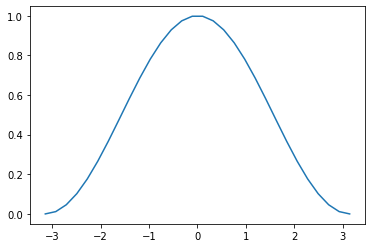

In [141]:
x = np.linspace(-np.pi, np.pi, 30)
_ = plt.plot(x, (1 + np.cos(x))/2  )

The following senario is for lockdown oscillating between total to semi open ( doubling time of 9 days, which is higher than South Korea but below all european country.
The growth rate oscillate between doubling every 10 days to no growth at all. It's between South Korea and Iran. What is tricky is that changing this max growth rate change quite a bit the outcome.

In [142]:
plot(66900000, 10, 12000, number_of_days_to_simulate=400, with_annealing=(1 + np.cos(np.linspace(-np.pi, np.pi, 90))/2 )) 

daily increase : 7.0 % 1.07


We end up with several spikes and hard period for hospitals with a pike with 8k people having severe symptoms, the number of cases diminish after lock downs.
38k death in 1 year

# Last scenario seasonal with lock down oscilations

In [143]:
plot(66900000, 10, 12000, number_of_days_to_simulate=400, 
     with_annealing=(1 + np.cos(np.linspace(-np.pi, np.pi, 45))/2 ), 
     with_season=(1 + np.cos(np.linspace(portion_of_year, 2*np.pi +portion_of_year, 365))/2 )) 

daily increase : 7.0 % 1.07


In this scenario, we can see that the worst would be next winter. <br>
Of course the scenarios running so far in the future are really speculative. Hard to predict when a cure or a vaccine will be discovered, when progress in testing will allow to do massive are fast campaigns of tests to detect cases early and reduce the probability to spread.
<br>
To conclude, as we are dealing with an exponential growth, modifying even slightly some parameters end up with results radically different. I am machine learning engineer and develop this notebook on my free time, i am not epidemiologist so the goal of the notebook is more to illustrate the mechanisms of a spread of a virus and not to give accurate predictions.